In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import batch_normalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
zip_dataset_path = '/content/gdrive/MyDrive/eFarma/Datasets/corn-or-maize-leaf-disease-dataset.zip' # Edit
!unzip $zip_dataset_path

In [ ]:
dataset_dir = '/content/data' # Edit

EPOCHS = 25
INIT_LR = 1e-3
batch_size = 32
img_len = 128
depth=3
default_image_size = tuple((img_len, img_len))
image_size = 0

In [ ]:
label_list = listdir(dataset_dir)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


In [ ]:
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_len, img_len), batch_size=batch_size, class_mode='categorical', subset='training')

Found 3352 images belonging to 4 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_len, img_len), batch_size=batch_size, class_mode='categorical', subset='validation')

Found 836 images belonging to 4 classes.


In [ ]:
model = Sequential()
inputShape = (img_len, img_len, depth)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (depth, img_len, img_len)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(batch_normalization.BatchNormalization())
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        1

In [ ]:
hist = model.fit(x = train_generator, validation_data = validation_generator, epochs = EPOCHS)

Epoch 1/25
105/105 [==============================] - 45s 330ms/step - loss: 0.3062 - accuracy: 0.8097 - val_loss: 0.8677 - val_accuracy: 0.3804
Epoch 2/25
105/105 [==============================] - 32s 308ms/step - loss: 0.1684 - accuracy: 0.8744 - val_loss: 1.1131 - val_accuracy: 0.2775
Epoch 3/25
105/105 [==============================] - 32s 305ms/step - loss: 0.1475 - accuracy: 0.8801 - val_loss: 1.0250 - val_accuracy: 0.3134
Epoch 4/25
105/105 [==============================] - 32s 301ms/step - loss: 0.1265 - accuracy: 0.8995 - val_loss: 0.5624 - val_accuracy: 0.4450
Epoch 5/25
105/105 [==============================] - 31s 300ms/step - loss: 0.1221 - accuracy: 0.9013 - val_loss: 0.1392 - val_accuracy: 0.8864
Epoch 6/25
105/105 [==============================] - 32s 304ms/step - loss: 0.1012 - accuracy: 0.9171 - val_loss: 1.8389 - val_accuracy: 0.5526
Epoch 7/25
105/105 [==============================] - 32s 309ms/step - loss: 0.1060 - accuracy: 0.9212 - val_loss: 0.1778 - val_ac

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(val_loss, val_accuracy)

27/27 [==============================] - 7s 242ms/step - loss: 0.2673 - accuracy: 0.8421
0.2672923803329468 0.8421052694320679


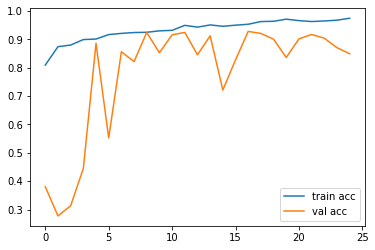

In [ ]:
# plot the accuracy
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

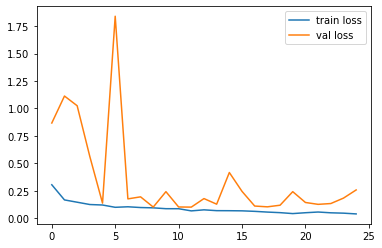

In [ ]:
# plot the loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Predict

In [ ]:
def predict(img_path):
    img = load_img(img_path, target_size=(img_len, img_len))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = datagen.flow(img)

    pre = model.predict(img)
    order = np.array(pre).argsort()[0][::-1]
    return order

In [ ]:
total = 0
for category in listdir(dataset_dir):
    path = dataset_dir + '/' + category
    imgs = listdir(path)
    print(f'{category}', end=' ')
    imgs = imgs[:10]
    count = 0
    for img_name in imgs:
        img_path = path + '/' + img_name
        out = predict(img_path)[0]
        if label_binarizer.classes_[out] == category:
            count+=1
    accuracy = count/len(imgs)
    total += accuracy
    print(f'{accuracy*100}%')

print(f'\nAverage Accuracy: {(total/len(listdir(dataset_dir)))*100}%')

Gray_Leaf_Spot 90.0%
Common_Rust 100.0%
Healthy 100.0%
Blight 60.0%

Average Accuracy: 87.5%


Save model

In [ ]:
root_dir = '/content/gdrive/MyDrive/eFarma/Leaf Disease Detection/output/corn' # Edit
model_name = 'corn' # Edit

In [ ]:
pickle.dump(label_binarizer, open(root_dir + f'/{model_name}_labels.pkl', 'wb'))

model_json = model.to_json()
with open(root_dir + "/" + model_name + ".json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(root_dir + "/" + model_name + ".h5")

Save sample Images

In [ ]:
!mkdir test_imgs

max_per_cat = 5 # Edit
for category in listdir(dataset_dir):
    path = dataset_dir + '/' + category
    imgs = listdir(path)[:max_per_cat]
    count = 0
    for i in range(len(imgs)):
        img_name = imgs[i]
        img_path = path + '/' + img_name
        img = cv2.imread(img_path)
        cv2.imwrite(f'test_imgs/{category}_{i}.jpg', img)
        count+=1
        if count == max:
            break
    print(f'Images from {category} saved')

print('Compressing imgs')
!zip -r /content/test_imgs.zip test_imgs
print('Saving to drive')
temp = f'"{root_dir}"'
!cp test_imgs.zip $temp
print('Done')

In [ ]:
# !rm -r test_imgs